In [11]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def euclidean_dist(a, b):
    return np.linalg.norm(a - b)

def cosine_dist(a, b):
    # Cosine Similarity
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a == 0 or norm_b == 0: return 1.0
    return 1 - np.dot(a, b) / (norm_a * norm_b)

def jaccard_dist(a, b):
    # Generalized Jaccard (Soergel Distance)
    numer = np.sum(np.minimum(a, b))
    denom = np.sum(np.maximum(a, b))
    if denom == 0: return 1.0
    return 1 - (numer / denom)

# K-Means Class 
class KMeansScratch:
    def __init__(self, k, metric='euclidean', max_iter=500, stop_condition='centroid_change', tol=1e-6):
        self.k = k
        self.max_iter = max_iter
        self.metric_name = metric
        self.stop_condition = stop_condition
        self.tol = tol
        self.centroids = None
        self.labels = None
        self.sse_history = []
        self.iterations = 0
        self.elapsed_time = 0
        
        # Map string to function
        if metric == 'euclidean': self.dist_func = euclidean_dist
        elif metric == 'cosine': self.dist_func = cosine_dist
        elif metric == 'jaccard': self.dist_func = jaccard_dist

    def fit(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        
        # Random Initialization (Fixed seed for reproducibility)
        rng = np.random.default_rng(42)
        indices = rng.choice(n_samples, self.k, replace=False)
        self.centroids = X[indices]
        self.sse_history = []
        
        start_time = time.time()
        
        for i in range(self.max_iter):
            self.iterations = i + 1
            
            # Assign Clusters
            distances = np.array([[self.dist_func(row, c) for c in self.centroids] for row in X])
            self.labels = np.argmin(distances, axis=1)
            
            # Calculate SSE using the specific metric logic (sum of squared distances)
            current_sse = 0
            for idx, label in enumerate(self.labels):
                d = self.dist_func(X[idx], self.centroids[label])
                current_sse += d**2
            
            # Check SSE Increase Stop Condition
            if self.stop_condition == 'sse_increase':
                if i > 0 and current_sse > self.sse_history[-1]:
                    break
            
            self.sse_history.append(current_sse)
            
            # Update Centroids
            new_centroids = np.array([
                X[self.labels == j].mean(axis=0) if np.sum(self.labels == j) > 0 
                else self.centroids[j] 
                for j in range(self.k)
            ])
            
            # Check Centroid Change Stop Condition
            if self.stop_condition == 'centroid_change':
                centroid_shift = np.linalg.norm(new_centroids - self.centroids)
                if centroid_shift < self.tol:
                    self.centroids = new_centroids
                    break
            
            self.centroids = new_centroids
            
        self.elapsed_time = time.time() - start_time
        return self

# Accuracy Helper
def get_accuracy(true_labels, pred_labels):
    cluster_map = {}
    # Map clusters to labels using majority vote
    for cluster_id in np.unique(pred_labels):
        indices = np.where(pred_labels == cluster_id)[0]
        if len(indices) == 0: continue
        true_labels_in_cluster = true_labels[indices]
        most_common = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_map[cluster_id] = most_common
    
    mapped_preds = np.array([cluster_map.get(l, -1) for l in pred_labels])
    return np.mean(mapped_preds == true_labels)

Data loaded. N=10000, K=10
Running algorithms (please wait)...
       Q1 OUTPUT: SSE Comparison        
Euclidean    SSE: 25466788154.4893
Cosine       SSE: 686.4465
Jaccard      SSE: 3660.3954
     Q2 OUTPUT: Accuracy Comparison     
Euclidean    Accuracy: 0.6419
Cosine       Accuracy: 0.6311
Jaccard      Accuracy: 0.6027


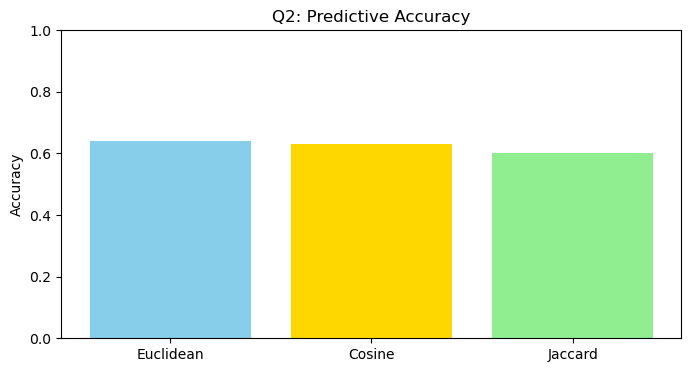

In [12]:
try:
    X = pd.read_csv('data/task1/data.csv', header=None).values
    y = pd.read_csv('data/task1/label.csv', header=None).values.ravel()
    K = len(np.unique(y))
    print(f"Data loaded. N={len(X)}, K={K}")
except Exception as e:
    print(f"Error loading data: {e}")
    X = np.random.rand(150, 5)
    y = np.random.randint(0, 3, 150)
    K = 3

metrics = ['euclidean', 'cosine', 'jaccard']
# Store results to print separately
results_store = {'Method': [], 'SSE': [], 'Accuracy': []}

# Run Models (Calculate data once)
print("Running algorithms (please wait)...")
for m in metrics:
    # Run model
    model = KMeansScratch(k=K, metric=m, stop_condition='centroid_change')
    model.fit(X)
    
    # Calculate metrics
    acc = get_accuracy(y, model.labels)
    sse = model.sse_history[-1]
    
    # Store
    results_store['Method'].append(m.capitalize())
    results_store['SSE'].append(sse)
    results_store['Accuracy'].append(acc)

print(f"{'Q1 OUTPUT: SSE Comparison':^40}")
for i, m in enumerate(results_store['Method']):
    print(f"{m:<12} SSE: {results_store['SSE'][i]:.4f}")

print(f"{'Q2 OUTPUT: Accuracy Comparison':^40}")
for i, m in enumerate(results_store['Method']):
    print(f"{m:<12} Accuracy: {results_store['Accuracy'][i]:.4f}")

plt.figure(figsize=(8, 4))
plt.bar(results_store['Method'], results_store['Accuracy'], color=['skyblue', 'gold', 'lightgreen'])
plt.title('Q2: Predictive Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.show()


Running Q3 (Convergence Speed)
euclidean: 39 iters, 10.8195 sec
cosine: 46 iters, 22.9550 sec
jaccard: 145 iters, 82.5072 sec


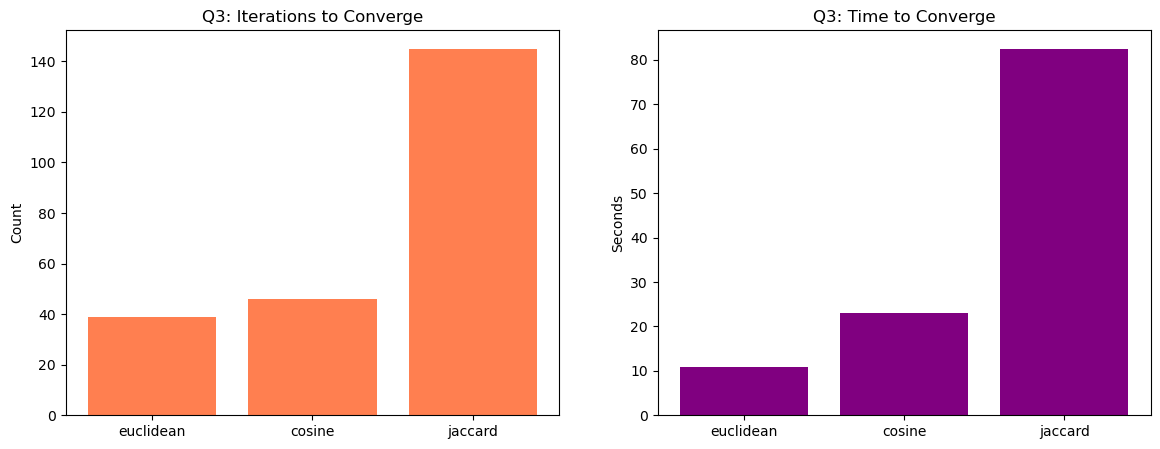

In [13]:
q3_data = {'Iterations': [], 'Time': []}

print("\nRunning Q3 (Convergence Speed)")
for m in metrics:
    # Using standard convergence check
    model = KMeansScratch(k=K, metric=m, stop_condition='centroid_change')
    model.fit(X)
    
    q3_data['Iterations'].append(model.iterations)
    q3_data['Time'].append(model.elapsed_time)
    print(f"{m}: {model.iterations} iters, {model.elapsed_time:.4f} sec")

# Plotting Q3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(metrics, q3_data['Iterations'], color='coral')
ax1.set_title('Q3: Iterations to Converge')
ax1.set_ylabel('Count')

ax2.bar(metrics, q3_data['Time'], color='purple')
ax2.set_title('Q3: Time to Converge')
ax2.set_ylabel('Seconds')

plt.show()


Running Q4 (Stopping Conditions)
                    euclidean      cosine      jaccard
centroid_change  2.546679e+10  686.446527  3660.395414
sse_increase     2.546679e+10  686.276192  3754.722563
max_iter_100     2.546679e+10  686.446527  3662.330436


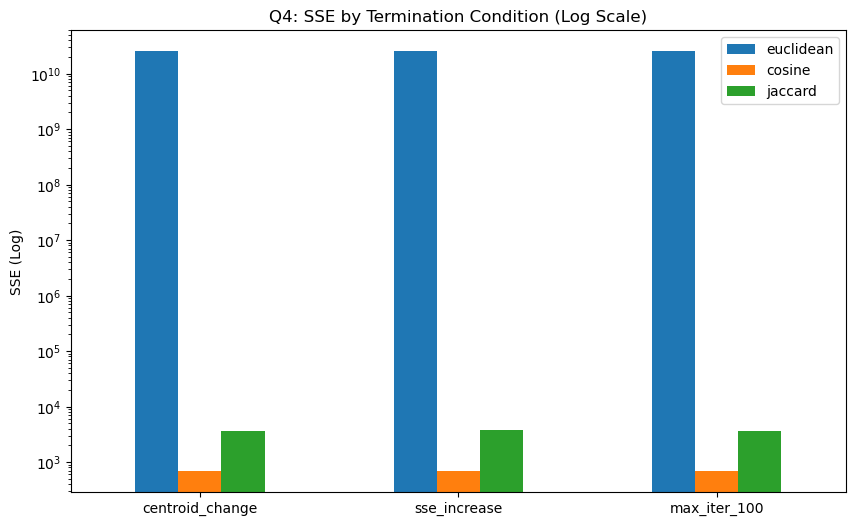

In [14]:
conditions_map = {
    'centroid_change': {'stop': 'centroid_change', 'iter': 500},
    'sse_increase':    {'stop': 'sse_increase', 'iter': 500},
    'max_iter_100':    {'stop': 'centroid_change', 'iter': 100}
}

results_q4 = {}

print("\nRunning Q4 (Stopping Conditions)")
for m in metrics:
    results_q4[m] = {}
    for cond_name, params in conditions_map.items():
        model = KMeansScratch(k=K, metric=m, max_iter=params['iter'], stop_condition=params['stop'])
        model.fit(X)
        results_q4[m][cond_name] = model.sse_history[-1]

df_q4 = pd.DataFrame(results_q4)
print(df_q4)

df_q4.plot(kind='bar', figsize=(10, 6), logy=True)
plt.title('Q4: SSE by Termination Condition (Log Scale)')
plt.ylabel('SSE (Log)')
plt.xticks(rotation=0)
plt.show()

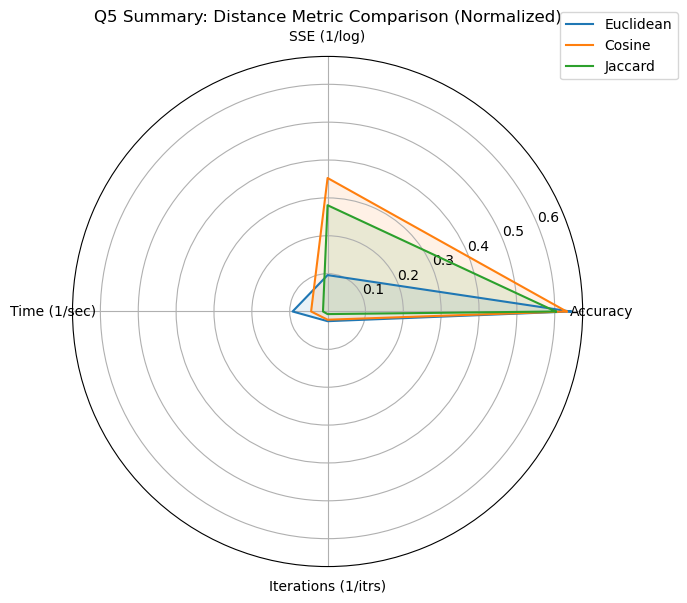

In [15]:
# Using the values calculated in previous cells to populate the chart dynamically
labels = ['Euclidean', 'Cosine', 'Jaccard']
chart_metrics = ['Accuracy', 'SSE (1/log)', 'Time (1/sec)', 'Iterations (1/itrs)']

acc_vals = results_store['Accuracy']
sse_vals = [1 / np.log10(x) if x > 0 else 0 for x in results_store['SSE']]
time_vals = [1 / x if x > 0 else 0 for x in q3_data['Time']]
iter_vals = [1 / x if x > 0 else 0 for x in q3_data['Iterations']]

data = [acc_vals, sse_vals, time_vals, iter_vals]

# Setup Radar Chart
angles = np.linspace(0, 2 * np.pi, len(chart_metrics), endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for i, label in enumerate(labels):
    # Extract values for this metric across all categories
    values = [data[j][i] for j in range(len(chart_metrics))]
    values += values[:1] # Close the loop
    
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(chart_metrics)
ax.set_title('Q5 Summary: Distance Metric Comparison (Normalized)')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()